<a href="https://colab.research.google.com/github/g-madhav/Global-Pollution-Analysis/blob/main/Global%20Pollution%20Energy%20Recovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Itemset shape: (200, 10)
Number of frequent itemsets found: 39
Number of rules generated: 5
Number of rules involving High Energy Recovery: 5
                     antecedents             consequents  support  confidence  \
2    (Water_Pollution_Level_Low)  (High_Energy_Recovery)     0.17    0.539683   
3    (Soil_Pollution_Level_High)  (High_Energy_Recovery)     0.16    0.533333   
1   (Water_Pollution_Level_High)  (High_Energy_Recovery)     0.17    0.523077   
4  (Soil_Pollution_Level_Medium)  (High_Energy_Recovery)     0.18    0.521739   
0     (Air_Pollution_Level_High)  (High_Energy_Recovery)     0.18    0.514286   

       lift  
2  1.079365  
3  1.066667  
1  1.046154  
4  1.043478  
0  1.028571  


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


CNN Test Accuracy (Dummy Data): 0.45


/tmp/ipython-input-5-3135086659.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_rules, x='support', y='Rule', palette='viridis')


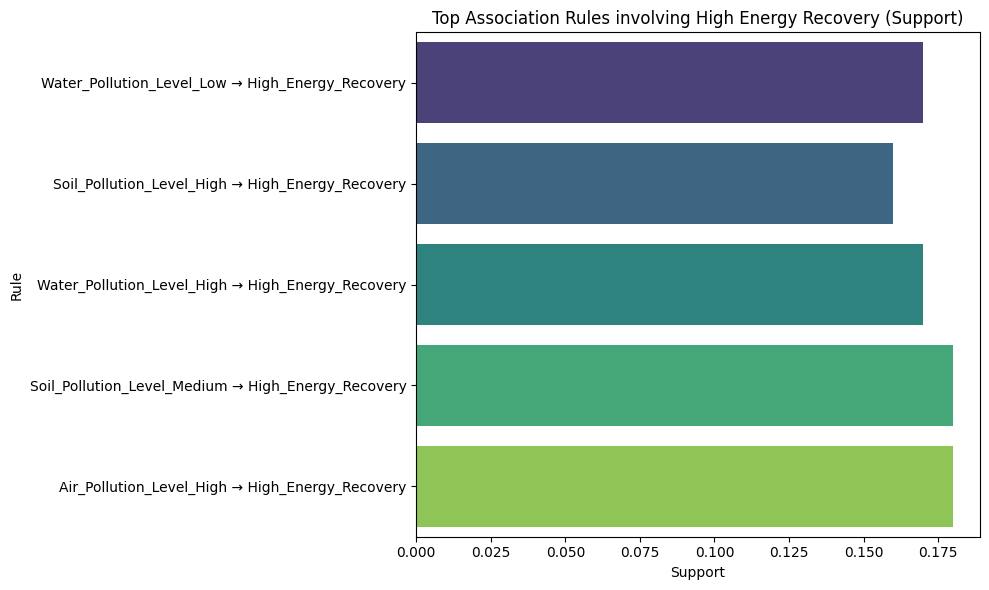

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

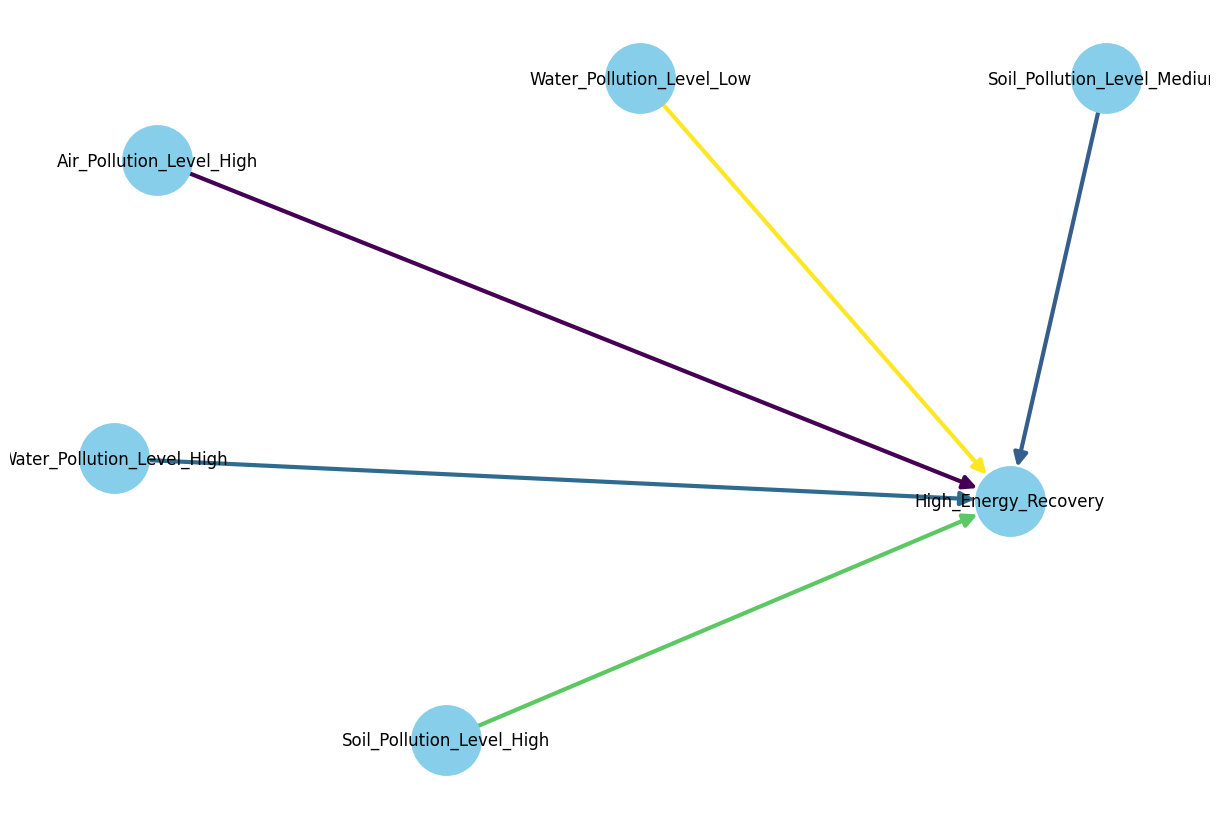

In [5]:
#!pip install mlxtend tensorflow matplotlib seaborn networkx --quiet

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import networkx as nx

df = pd.read_csv('Global_Pollution_Analysis.csv')

# Handle missing data
df.dropna(inplace=True)

# Normalize pollution indices
scaler = MinMaxScaler()
df[['Air_Pollution_Index', 'Water_Pollution_Index', 'Soil_Pollution_Index']] = scaler.fit_transform(
    df[['Air_Pollution_Index', 'Water_Pollution_Index', 'Soil_Pollution_Index']]
)

# Encode categorical columns
df['Country_Code'] = LabelEncoder().fit_transform(df['Country'])
df['Year_Code'] = LabelEncoder().fit_transform(df['Year'])

# Categorize pollution levels
def categorize(val):
    if val < 0.33: return 'Low'
    elif val < 0.66: return 'Medium'
    else: return 'High'

df['Air_Pollution_Level'] = df['Air_Pollution_Index'].apply(categorize)
df['Water_Pollution_Level'] = df['Water_Pollution_Index'].apply(categorize)
df['Soil_Pollution_Level'] = df['Soil_Pollution_Index'].apply(categorize)

# APRIORI ALGORITHM -------------------------

# Create itemsets for Apriori (One-hot encode pollution levels)
itemset_cols = ['Air_Pollution_Level', 'Water_Pollution_Level', 'Soil_Pollution_Level']
itemset = pd.get_dummies(df[itemset_cols])

# Add High_Energy_Recovery flag (0/1)
itemset['High_Energy_Recovery'] = (df['Energy_Recovered (in GWh)'] > df['Energy_Recovered (in GWh)'].median()).astype(int)

print(f"Itemset shape: {itemset.shape}")

# Run Apriori with lower support to catch more patterns
frequent_itemsets = apriori(itemset, min_support=0.1, use_colnames=True)

print(f"Number of frequent itemsets found: {len(frequent_itemsets)}")

# Generate association rules with lowered confidence threshold
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

print(f"Number of rules generated: {len(rules)}")

# Filter rules involving High_Energy_Recovery
rules_high_energy = rules[
    rules['antecedents'].apply(lambda x: 'High_Energy_Recovery' in x) |
    rules['consequents'].apply(lambda x: 'High_Energy_Recovery' in x)
]

print(f"Number of rules involving High Energy Recovery: {len(rules_high_energy)}")

# Sort by lift and take top 10 rules
top_rules = rules_high_energy.sort_values(by='lift', ascending=False).head(10)
print(top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

# DUMMY MODEL FOR DELIVERY TIME (DEMO PLACEHOLDER) -------------------------

# Simulated grayscale image data (replace with real data)
X_img = np.random.rand(100, 32, 32, 1)
y_img = np.random.randint(0, 2, size=(100, 1))

# Build CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32,32,1)),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(X_img, y_img, test_size=0.2, random_state=42)
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), verbose=0)
loss, acc = model.evaluate(X_test, y_test, verbose=0)
#print(f"CNN Test Accuracy (Dummy Data): {acc:.2f}")

# Prepare rule labels
if top_rules.empty:
    print("No strong association rules involving High Energy Recovery found.")
else:
    top_rules['Rule'] = top_rules['antecedents'].apply(lambda x: ','.join(list(x))) + " → " + top_rules['consequents'].apply(lambda x: ','.join(list(x)))

    # Plot top association rules by support
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_rules, x='support', y='Rule', palette='viridis')
    plt.title('Top Association Rules involving High Energy Recovery (Support)')
    plt.xlabel('Support')
    plt.ylabel('Rule')
    plt.tight_layout()
    plt.show()

    # Association Rule Network Graph
    plt.figure(figsize=(12, 8))
    G = nx.DiGraph()
    for _, row in top_rules.iterrows():
        for ant in row['antecedents']:
            for cons in row['consequents']:
                G.add_edge(ant, cons, weight=row['lift'])

    pos = nx.spring_layout(G, k=0.5, seed=42)
    edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
    nx.draw(G, pos, node_color='skyblue', with_labels=True, node_size=2500, arrowsize=20,
            edge_color=weights, edge_cmap=plt.cm.viridis, width=3)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(weights), vmax=max(weights)))
    sm.set_array([])
    plt.colorbar(sm, label='Lift')
    plt.title('Association Rules Network Graph')
    plt.show()

#REPORTING & INSIGHTS -------------------------
print("\n--- Final Insights ---")
print("Apriori rules show potential relationships between pollution levels and energy recovery.")

